In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from graphviz import Digraph

def trace(root):
    # builds set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular ("record") node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}"%(n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is result of some operation, create op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and conncet this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect the n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [63]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # 0 means no effect, we are assuming that it does not effect 
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self) -> str:
        return (f"Value(data={self.data})")
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers as of now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other = self
        return self * other
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), label="exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
#inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

# output
o = n.tanh(); o.label = "o"

o.backward()

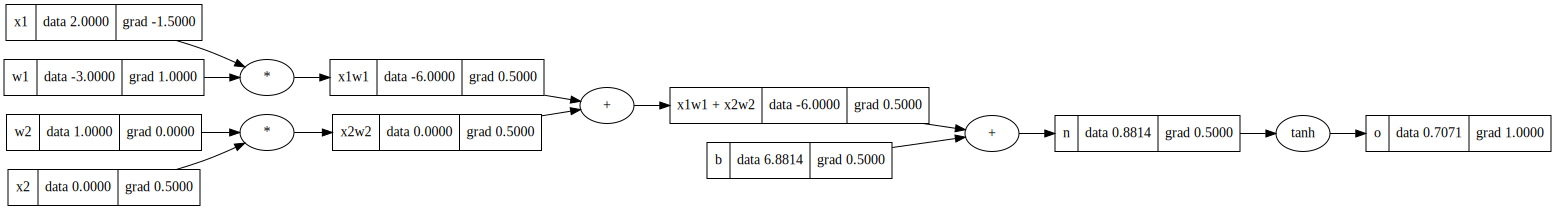

In [5]:
draw_dot(o)

Using pytorch API

In [7]:
import torch

In [8]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print("x2", x2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("w2", w2.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


Building out Neural Net library (MLP) using micrograd

In [9]:
import random

In [69]:
class Neuron:
    def __init__(self, nin):
        # nin = number of inputs    
        self.w  = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # zip will pair wis with xis
        
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        # nout is how many neurons we want in a layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron  in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    def __init__(self, nin, nouts):
        # nouts is list of nouts. This list defines sizes of all the layers 
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [78]:
x = [2.0, 3.0, -1.0]
# n = Neuron(2)
# n = Layer(2, 3) # 2 inputs and 3 neurons in layer
n = MLP(3, [4, 4, 1]) # 3 inputs and 3 layers of 4, 4, and 1 neurons respectively
n(x)

Value(data=-0.10285069210992821)

In [79]:
len(n.parameters())

41

In [80]:
# dummy dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, 1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # targets

y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.10285069210992821),
 Value(data=0.4749534556779886),
 Value(data=0.24396887544645812),
 Value(data=0.22800157218638456)]

In [81]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
loss # loss earlier

Value(data=5.535207481130008)

In [82]:
loss.backward()

In [84]:
n.layers[0].neurons[0].w[0].grad

-0.08665548456077668

In [83]:
n.layers[0].neurons[0].w[0].data

-0.06803039891503215

In [85]:
for p in n.parameters():
    p.data += -0.01*p.grad

In [86]:
n.layers[0].neurons[0].w[0].data

-0.06716384406942438

In [87]:
y_pred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
loss # loss after. Indeed it has decreased

Value(data=5.203833937970769)

Now we have to iterate the process:
- Forward pass i.e make a prediction
- Calculate the loss
- Backward pass i.e calculate the gradients
- Update the weights
- Repeat

In [91]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3 inputs and 3 layers of 4, 4, and 1 neurons respectively

# dummy dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, 1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # targets

for k in range(20):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
    
    # backward pass
    for p in n.parameters():
        # need to flush the old gradients before calculating the new one in new step
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data, )

0 3.555361628002481
1 3.050566984791442
2 2.76647033898638
3 2.678377391881124
4 2.6636429826981582
5 2.6520639730233317
6 2.6416959894577294
7 2.6318837064934724
8 2.6221835624717142
9 2.612251922042371
10 2.6017865087835603
11 2.590489444531164
12 2.5780391451564917
13 2.564064455514045
14 2.5481167716417987
15 2.5296368451813174
16 2.5079134561957255
17 2.482032085187041
18 2.450814746939967
19 2.4127609021987633


In [92]:
y_pred # we are almost there

[Value(data=0.4143630243278529),
 Value(data=-0.9115666746546803),
 Value(data=0.23984654373866487),
 Value(data=0.2756034719354321)]